In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dipy
from dipy.reconst.ivim import IvimModel
import dipy.core.gradients as dpg
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti_data

In [2]:
fraw, fbval, fbvec = get_fnames('ivim')

In [3]:
sim_bvecs = dpg.generate_bvecs(6)

In [4]:
data = load_nifti_data(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs, b0_threshold=0)

In [5]:
sim_bvecs = np.vstack([sim_bvecs]* len(gtab.bvals[1:]))

In [6]:
sim_bvecs = np.vstack([np.array([[0, 0, 0]]), sim_bvecs])

In [7]:
sim_bvals = np.hstack(list([[gtab.bvals[1:][i]] * 6] for i in range(len(gtab.bvals[1:])))).squeeze()

In [8]:
sim_bvals = np.hstack([0, sim_bvals])

In [9]:
sim_bvals.shape

(121,)

In [10]:
sim_bvecs.shape

(121, 3)

In [11]:
sim_gtab = gradient_table(sim_bvals, sim_bvecs, b0_threshold=0)

$\frac{S}{S_0} = \beta e^{-b \theta^t Q^{*}, \theta} + (1- \beta) e^{-b \theta^t Q \theta}$


In [12]:
from dipy.reconst.dti import lower_triangular, from_lower_triangular

In [13]:
theta = sim_gtab.bvecs

In [14]:
def ivim_tensor(b, *params): 
    """ 
    
    """
    beta = params[0]
    Q = from_lower_triangular(np.array(params[1:7]))
    Q_star = from_lower_triangular(np.array(params[7:]))
    return beta * np.exp(-b * np.diag(theta @ Q_star @ theta.T)) + (1 - beta) * np.exp(-b * np.diag(theta @ Q @ theta.T))
    

In [15]:
Q = lower_triangular(np.array([[0.0015, 0, 0], [0, 0.001, 0], [0, 0, 0.001]]))
Q_star = 10 * Q

#theta = np.array([[1, 0, 0]])
beta = 0.2

In [16]:
len(np.hstack((beta, Q, Q_star)))

13

In [17]:
params = np.hstack([beta, Q, Q_star])

In [18]:
np.array(params[1:7])

array([0.0015, 0.    , 0.001 , 0.    , 0.    , 0.001 ])

In [19]:
signal = ivim_tensor(sim_gtab.bvals, *params)

In [20]:
signal = signal+np.random.randn(signal.shape[0]) * 0.05

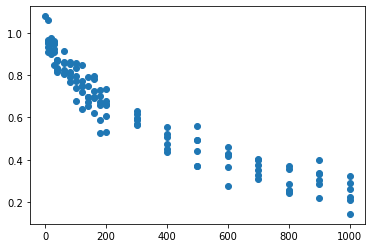

In [21]:
plt.plot(sim_gtab.bvals, signal, 'o')

In [22]:
from scipy.optimize import curve_fit

In [23]:
popt, pcov = curve_fit(ivim_tensor, sim_gtab.bvals, signal, p0=np.hstack((beta, Q, Q_star)))

In [24]:
popt

array([ 2.32328311e-01,  1.46175110e-03, -1.32937571e-05,  9.20986607e-04,
       -5.81476002e-05, -3.59110582e-05,  9.39132216e-04,  1.56095487e-02,
        3.65779718e-03,  9.15284980e-03, -1.79205059e-05, -1.92234823e-04,
        5.74700058e-03])

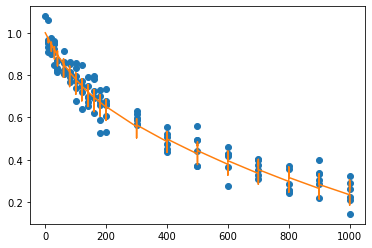

In [25]:
plt.plot(sim_gtab.bvals, signal, 'o')
plt.plot(sim_gtab.bvals, ivim_tensor(sim_gtab.bvals, *popt))

In [26]:
beta_hat = popt[0]
Q_hat = from_lower_triangular(np.array(popt[1:7]))
Q_star_hat = from_lower_triangular(np.array(popt[7:]))


In [27]:
from dipy.reconst import dti

In [28]:
beta_hat, dti.decompose_tensor(Q_hat), dti.decompose_tensor(Q_star_hat)

(0.2323283107116781,
 (array([0.0014683 , 0.0009644 , 0.00088917]),
  array([[-0.99399725,  0.07125846,  0.08301627],
         [ 0.01705258, -0.64861277,  0.76092751],
         [ 0.10806794,  0.7577755 ,  0.64350417]])),
 (array([0.01726069, 0.0075184 , 0.00573031]),
  array([[-0.91142617, -0.41027367, -0.03127071],
         [-0.4113802 ,  0.90707526,  0.0893354 ],
         [ 0.00828708, -0.09428677,  0.99551059]])))

In [29]:
from dipy.sims.voxel import multi_tensor

In [30]:
mevals = np.array([[0.001, 0.0005, 0.0005], 
                   [0.1, 0.01, 0.01]])

angles = [(90, 0), (90, 0)]

In [31]:
perfusion_fraction = 0.2

In [32]:
signal = multi_tensor(sim_gtab, mevals=mevals, snr=1000, fractions=[100 * (1-perfusion_fraction), 
                                                                    perfusion_fraction * 100])[0]

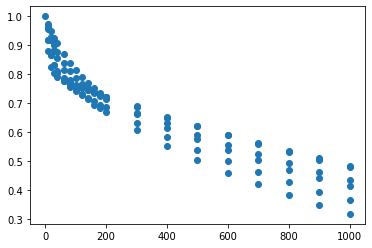

In [33]:
plt.plot(sim_gtab.bvals, signal, 'o')

In [34]:
model = IvimModel(sim_gtab, fit_method="trr")

/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/reconst/ivim.py:151: UserWarning: Bounds for this fit have been set from experiments and literature survey. To change the bounds, please input your bounds in model definition...
  warnings.warn(bounds_warning, UserWarning)


In [35]:
fit = model.fit(signal)

In [36]:
fit.D, fit.D_star, fit.perfusion_fraction

(array(0.00067363), array(0.02950537), array(0.17861453))

In [37]:
popt, pcov = curve_fit(ivim_tensor, sim_gtab.bvals, signal, p0=np.hstack((beta, Q, Q_star)))

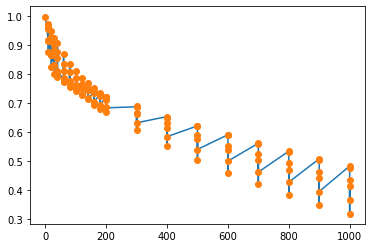

In [38]:
plt.plot(sim_gtab.bvals, ivim_tensor(sim_gtab.bvals, *popt))
plt.plot(sim_gtab.bvals, signal, 'o')

In [39]:
popt[0]

0.20027379939483542

In [40]:
beta_hat = popt[0]
Q_hat = from_lower_triangular(np.array(popt[1:7]))
Q_star_hat = from_lower_triangular(np.array(popt[7:]))


In [41]:
beta_hat, dti.decompose_tensor(Q_hat), dti.decompose_tensor(Q_star_hat)

(0.20027379939483542,
 (array([0.00099912, 0.00050004, 0.00049955]),
  array([[-1.13383887e-03,  3.93649564e-01,  9.19259884e-01],
         [-1.71467361e-03,  9.19258359e-01, -3.93651026e-01],
         [ 9.99997887e-01,  2.02256750e-03,  3.67310339e-04]])),
 (array([0.09865651, 0.01026793, 0.01000155]),
  array([[-9.99999764e-01,  2.26657459e-04, -6.48371577e-04],
         [-5.57134973e-04,  2.84402879e-01,  9.58704695e-01],
         [ 4.01696313e-04,  9.58704830e-01, -2.84402685e-01]])))

In [42]:
evals_Q_hat = dti.decompose_tensor(Q_hat)[0]

In [43]:
np.mean(evals_Q_hat)

0.0006662382434855677

In [44]:
evals_Q_star_hat = dti.decompose_tensor(Q_star_hat)[0]

In [45]:
np.mean(evals_Q_star_hat)

0.03964199692310323

In [46]:
pdd_Q_hat = dti.decompose_tensor(Q_hat)[1][0]

In [47]:
pdd_Q_hat_star =  dti.decompose_tensor(Q_star_hat)[1][0]

In [48]:
pdd_Q_hat, pdd_Q_hat_star

(array([-0.00113384,  0.39364956,  0.91925988]),
 array([-9.99999764e-01,  2.26657459e-04, -6.48371577e-04]))

In [49]:
np.rad2deg(np.arccos(np.dot(pdd_Q_hat, pdd_Q_hat_star)))

89.96407323886942

In [50]:
dti.fractional_anisotropy(evals_Q_star_hat)

0.8879523164336712

In [51]:
dti.fractional_anisotropy(evals_Q_hat)

0.40798743090444745

In [52]:
dti.mean_diffusivity(evals_Q_hat)

0.0006662382434855677

In [53]:
dti.mean_diffusivity(mevals[0])

0.0006666666666666666

In [54]:
dti.mean_diffusivity(evals_Q_star_hat)

0.03964199692310323

In [55]:
dti.mean_diffusivity(mevals[1])

0.04

In [56]:
from dipy.reconst.base import ReconstFit, ReconstModel
from dipy.reconst.multi_voxel import multi_voxel_fit
from dipy.reconst.dti import TensorModel, TensorFit, decompose_tensor, from_lower_triangular

In [70]:
class IvimTensorModel(ReconstModel):
    def __init__(self, gtab, split_b_D=400.0, bounds=[]):
        ReconstModel.__init__(self, gtab)
        self.split_b_D = split_b_D
        self.bounds = bounds
        # Use two separate tensors for initial estimation:
        self.dti = TensorModel(self.gtab)
        
        self.split_idx = np.where(gtab.bvals >= self.split_b_D)    
        self.perfusion_gtab = gradient_table(self.gtab.bvals[self.split_idx],
                                             self.gtab.bvecs[self.split_idx])
        
        self.perfusion_model = TensorModel(self.perfusion_gtab)

    def model_eq1(self, b, *params): 
        """ 
        The model with fixed perfusion fraction
        """
        beta = self.perfusion_fraction
        Q = from_lower_triangular(np.array(params[:6]))
        Q_star = from_lower_triangular(np.array(params[6:]))
        return beta * np.exp(-b * np.diag(theta @ Q_star @ theta.T)) + (1 - beta) * np.exp(-b * np.diag(theta @ Q @ theta.T))

    def model_eq2(self, b, *params): 
        """ 
        The full model, including perfusion fraction
        """
        beta = params[0]
        Q = from_lower_triangular(np.array(params[1:7]))
        Q_star = from_lower_triangular(np.array(params[7:]))
        return beta * np.exp(-b * np.diag(theta @ Q_star @ theta.T)) + (1 - beta) * np.exp(-b * np.diag(theta @ Q @ theta.T))

    
    def fit(self, data, mask=None):
        """ 
        For now, we assume that data is from a single voxel, and we'll generalize later
        """
        # Fit a tensor to the entire data and data just up to split_b_D
        self.dti_fit = self.dti.fit(data, mask)
        self.q_initial = lower_triangular(self.dti_fit.quadratic_form)
        
        perfusion_data = data[self.split_idx]
        self.perfusion_fit = self.perfusion_model.fit(perfusion_data, mask)
        self.q_star_initial = lower_triangular(self.perfusion_fit.quadratic_form).squeeze()
        fractions_for_probe = np.arange(0, 0.5, 0.05)
        self.fits = np.zeros((fractions_for_probe.shape[0], 12))
        self.errs = np.zeros(fractions_for_probe.shape[0])
        self.beta = np.zeros(fractions_for_probe.shape[0])
        initial = np.hstack([self.q_initial, self.q_star_initial])
        # Instead of estimating perfusion_fraction directly, we start by finding 
        # a perfusion fraction that works for the other parameters
        for ii, perfusion_fraction in enumerate(fractions_for_probe):
            self.perfusion_fraction = perfusion_fraction
            popt, pcov = curve_fit(self.model_eq1,  self.gtab.bvals, data, p0=initial)
            err = np.sum(np.power(self.model_eq1(self.gtab.bvals, *popt) - data, 2))
            self.fits[ii] = popt
            self.errs[ii] = err
            self.beta[ii] = perfusion_fraction

        min_err = np.argmin(self.errs)
        initial = np.hstack([self.beta[min_err], self.fits[min_err]])
        popt, pcov = curve_fit(self.model_eq2,  self.gtab.bvals, data, p0=initial, 
                               bounds=((0, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf), 
                                       (1, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))
        return IvimTensorFit(self, popt)
        
                            
class IvimTensorFit(ReconstFit):
    def __init__(self, model, model_params):
        self.model = model
        self.model_params = model_params
        tensor_evals, tensor_evecs = decompose_tensor(from_lower_triangular(self.model_params[1:7]))
        tensor_params = np.hstack([tensor_evals, tensor_evecs.ravel()])
        perfusion_evals, perfusion_evecs = decompose_tensor(from_lower_triangular(self.model_params[7:]))
        perfusion_params = np.hstack([perfusion_evals, perfusion_evecs.ravel()])
        self.tensor_fit = TensorFit(self.model.dti, tensor_params)
        self.perfusion_fit = TensorFit(self.model.perfusion_model, perfusion_params)
        self.perfusion_fraction = np.min([model_params[0], 1 - model_params[0]])

In [71]:
itm = IvimTensorModel(sim_gtab)

In [72]:
signal.shape, sim_gtab.bvals.shape

((121,), (121,))

In [73]:
itf = itm.fit(signal)

In [74]:
itf.tensor_fit.fa, itf.perfusion_fit.fa

(0.4080220344940902, 0.8914339165106906)

In [75]:
itf.tensor_fit.evals, itf.perfusion_fit.evals, itf.perfusion_fraction

(array([0.00100085, 0.00050088, 0.00050039]),
 array([0.10033515, 0.01005416, 0.00996102]),
 0.19992651812163367)

In [76]:
itf.tensor_fit.directions, itf.perfusion_fit.directions

(array([[-0.00143266, -0.00235472,  0.9999962 ]]),
 array([[-9.99998257e-01, -9.58438838e-04, -1.60228438e-03]]))

In [64]:
snrs = [1, 10, 20, 50, 100, 1000]
perfusion_fractions = [0.01, 0.05, 0.1, 0.15, 0.2]
reps = 50

fracs_discovered = np.zeros((len(snrs), len(perfusion_fractions), reps))

for ii in range(len(snrs)):
    snr = snrs[ii]
    for jj in range(len(perfusion_fractions)):
        perfusion_fraction = perfusion_fractions[jj]
        for rep in range(reps):
            signal = multi_tensor(sim_gtab, mevals=mevals, snr=snr, 
                                  fractions=[100 * (1-perfusion_fraction), 
                                  perfusion_fraction * 100])[0]
            try:
                itf = itm.fit(signal)
                fracs_discovered[ii, jj, rep] = itf.perfusion_fraction
            except RuntimeError:
                fracs_discovered[ii, jj, rep] = itf.perfusion_fraction
            

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:234: RuntimeWarning: overflow encountered in double_scalars
  ratio = actual_reduction / predicted_reduction


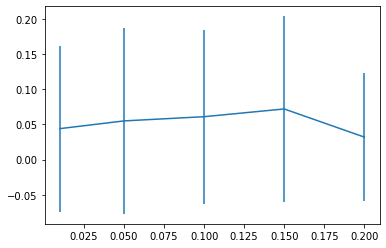

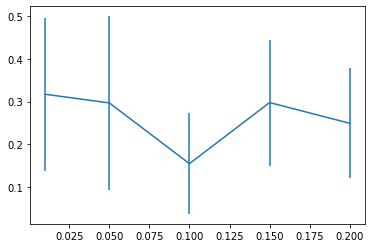

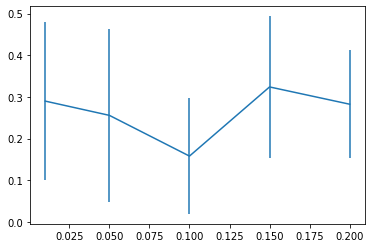

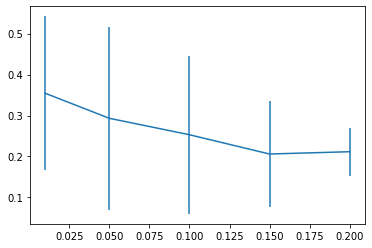

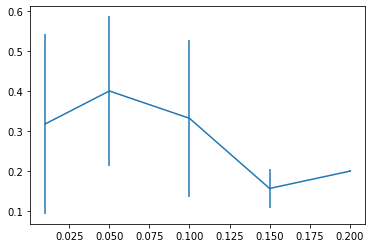

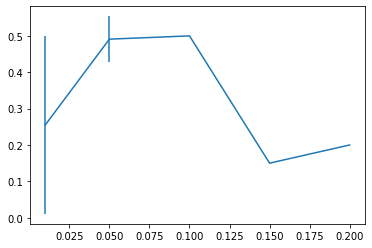

In [65]:
for ii in range(len(snrs)):
    fig, ax = plt.subplots()
    ax.errorbar(perfusion_fractions, np.mean(fracs_discovered, -1)[ii], yerr=np.std(1-fracs_discovered, -1)[ii])

In [66]:
np.mean(fracs_discovered, -1)[1]

array([0.31700968, 0.29676661, 0.1548834 , 0.29765632, 0.24930976])

In [67]:
np.mean(fracs_discovered, -1)

array([[0.0439997 , 0.05499793, 0.06099926, 0.07199929, 0.03199985],
       [0.31700968, 0.29676661, 0.1548834 , 0.29765632, 0.24930976],
       [0.28991572, 0.25576273, 0.15808772, 0.32391938, 0.2824795 ],
       [0.3543019 , 0.29322726, 0.25305879, 0.20597297, 0.21162853],
       [0.31846252, 0.40078021, 0.33252097, 0.15712983, 0.20026915],
       [0.25517343, 0.49099749, 0.5       , 0.1499575 , 0.19995683]])

In [68]:
itf.perfusion_fraction

0.19992651812326004

In [69]:
fracs_discovered[-1][-3]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])